# Pneunomia Detection using CNN, DenseNet
**Pneumonia is an inflammatory condition of the lung affecting primarily the small air sacs known as alveoli.Symptoms typically include some combination of productive or dry cough, chest pain, fever and difficulty breathing. The severity of the condition is variable. Pneumonia is usually caused by infection with viruses or bacteria and less commonly by other microorganisms, certain medications or conditions such as autoimmune diseases.Risk factors include cystic fibrosis, chronic obstructive pulmonary disease (COPD), asthma, diabetes, heart failure, a history of smoking, a poor ability to cough such as following a stroke and a weak immune system. Diagnosis is often based on symptoms and physical examination. Chest X-ray, blood tests, and culture of the sputum may help confirm the diagnosis.The disease may be classified by where it was acquired, such as community- or hospital-acquired or healthcare-associated pneumonia.**
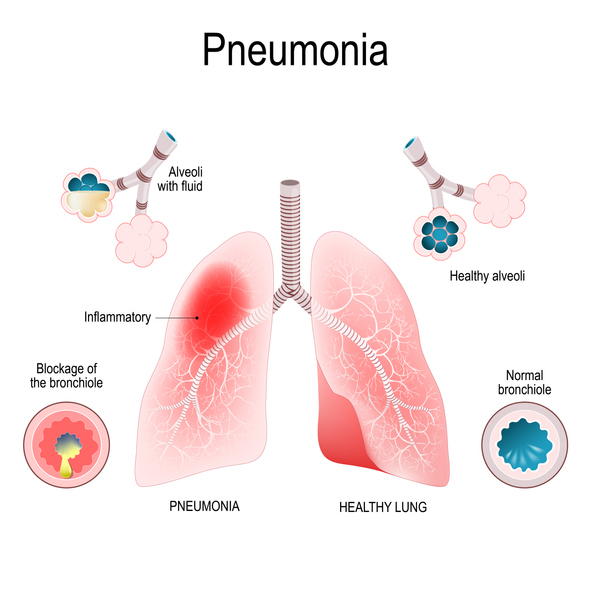

In [73]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/data-task1'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.


# Importing the necessary libraries

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential

from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization, 
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from keras.callbacks import ReduceLROnPlateau
import cv2
import os

# Description of the Pneumonia Dataset
**The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).
Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.
For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.**

In [75]:
labels = ['pneumonia', 'no_pneumonia']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir,label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

# Loading the Dataset

In [1]:
datadir = os.getcwd()
train = get_training_data(str(datadir)+'C:/Users/Computing/Downloads/data-task1/train/')
test = get_training_data(str(datadir)+'C:/Users/Computing/Downloads/data-task1/test/')
val = get_training_data(str(datadir)+'C:/Users/Computing/Downloads/data-task1/val/')

NameError: name 'os' is not defined

# Data Visualization & Preprocessing

(3000, 2)
(3000,)


c:\users\ghost\appdata\local\programs\python\python36\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


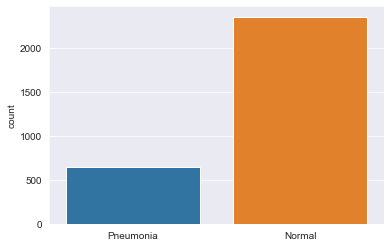

In [94]:
l = []
test_labels = []
for i in train:
    if(i[1] == 0):
        label = 0
        l.append("Pneumonia")
    else:
        label = 1
        l.append("Normal")
    test_labels.append(label)
test_labels = np.array(test_labels)
sns.set_style('darkgrid')
sns.countplot(l)   


**The data seems imbalanced . To increase the no. of training examples, we will use data augmentation**

**Previewing the images of both the classes**

Text(0.5, 1.0, 'no_pneumonia')

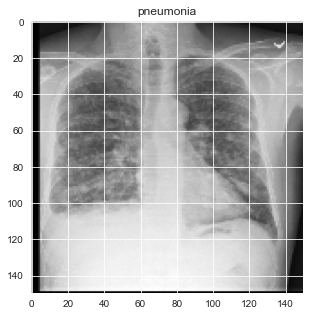

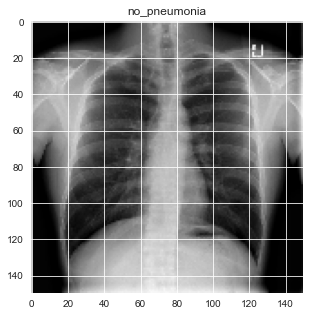

In [10]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [12]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

**We perform a grayscale normalization to reduce the effect of illumination's differences.Moreover the CNN converges faster on [0..1] data than on [0..255].**

In [13]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [14]:
# resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

# Data Augmentation
**In order to avoid overfitting problem, we need to expand artificially our dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations.
Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more.
By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.**

In [15]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

For the data augmentation, i choosed to :
1. Randomly rotate some training images by 30 degrees 
2. Randomly Zoom by 20% some training images
3. Randomly shift images horizontally by 10% of the width 
4. Randomly shift images vertically by 10% of the height 
5. Randomly flip images horizontally.
Once our model is ready, we fit the training dataset.

# Training the Model with DenseNet

In [16]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
#Adding DenseNet classifier to the model
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 38, 64)        0

In [17]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [18]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 12 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

Epoch 1/12
94/94 [==============================] - 63s 656ms/step - loss: 0.9288 - accuracy: 0.7427 - val_loss: 1.1577 - val_accuracy: 0.7800
Epoch 2/12
94/94 [==============================] - 62s 659ms/step - loss: 0.5082 - accuracy: 0.7927 - val_loss: 0.9092 - val_accuracy: 0.7440
Epoch 3/12
94/94 [==============================] - 62s 659ms/step - loss: 0.4948 - accuracy: 0.7927 - val_loss: 0.7361 - val_accuracy: 0.7680

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 4/12
94/94 [==============================] - 63s 669ms/step - loss: 0.4385 - accuracy: 0.8083 - val_loss: 0.7225 - val_accuracy: 0.7680
Epoch 5/12
94/94 [==============================] - 62s 660ms/step - loss: 0.4338 - accuracy: 0.8093 - val_loss: 0.6211 - val_accuracy: 0.7500

Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
Epoch 6/12
94/94 [==============================] - 62s 660ms/step - loss: 0.4181 - accuracy: 0.8147 - val_loss: 0.5541 - v

In [19]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

16/16 [==============================] - 2s 124ms/step - loss: 0.4888 - accuracy: 0.7660
Loss of the model is -  0.4888015389442444
16/16 [==============================] - 2s 124ms/step - loss: 0.4888 - accuracy: 0.7660
Accuracy of the model is -  76.5999972820282 %


# Analysis after Model Training

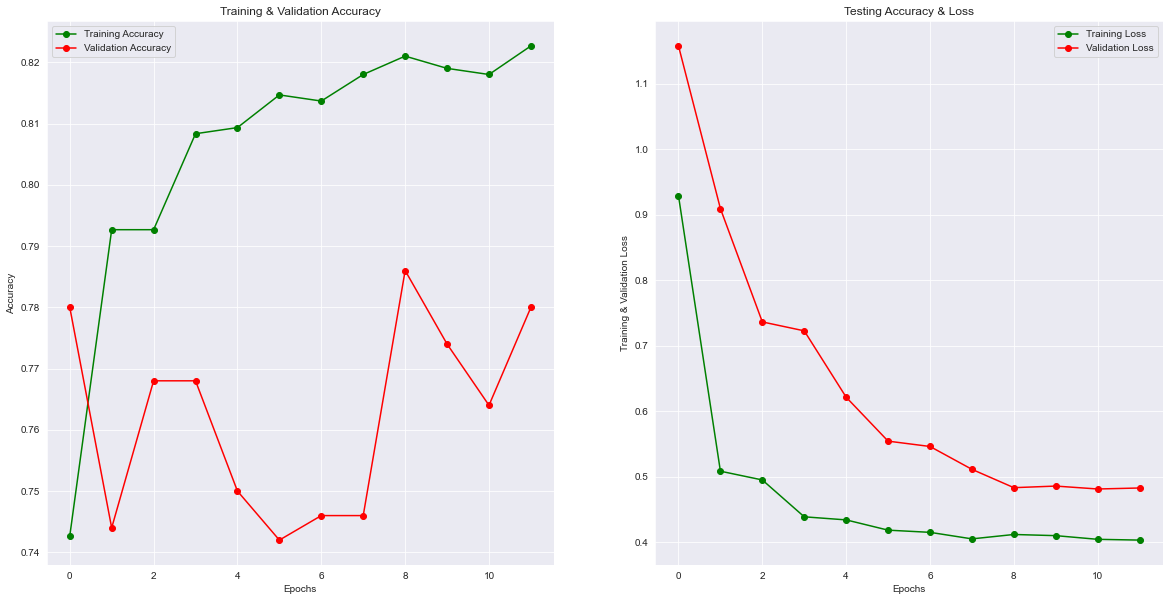

In [20]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()
# If the difference between training and validation error starts to increase, instead of decreasing. This is a symptom of overfitting

In [126]:
#https://stackoverflow.com/questions/68836551/keras-attributeerror-sequential-object-has-no-attribute-predict-classes solved issue with prediction vode being depretiated and not running
pred = model.predict(x_test)
predictions = np.round(pred)

array([[0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.]], dtype=float32)

In [1]:
#This is currently throwing a warning which can be ignored according to this discussion:
#https://github.com/Berkeley-Data/hpt/issues/52


acc = accuracy_score(y_test, predictions)*100
cm = confusion_matrix(y_test, predictions) 

tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((history.history['accuracy'][-1])*100, 2)))

#This does the same as the above in 1 line
#print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

NameError: name 'accuracy_score' is not defined

In [130]:
cm = confusion_matrix(y_test,predictions)
cm

array([[ 58,  47],
       [ 70, 325]], dtype=int64)

In [129]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

<AxesSubplot:>

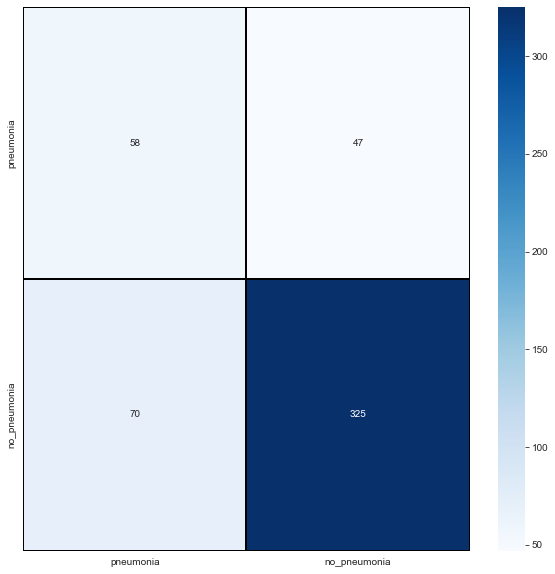

In [117]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [118]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

**Some of the Correctly Predicted Classes**

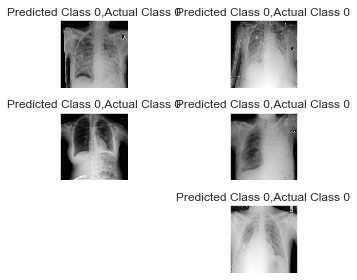

In [119]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

**Some of the Incorrectly Predicted Classes**

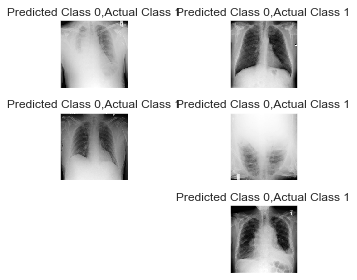

In [120]:
i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

In [ ]:
# Training the Model with DenseNet

In [ ]:
#model2
#https://www.kaggle.com/code/ashishpatel26/resnet50-pneumonia-detection